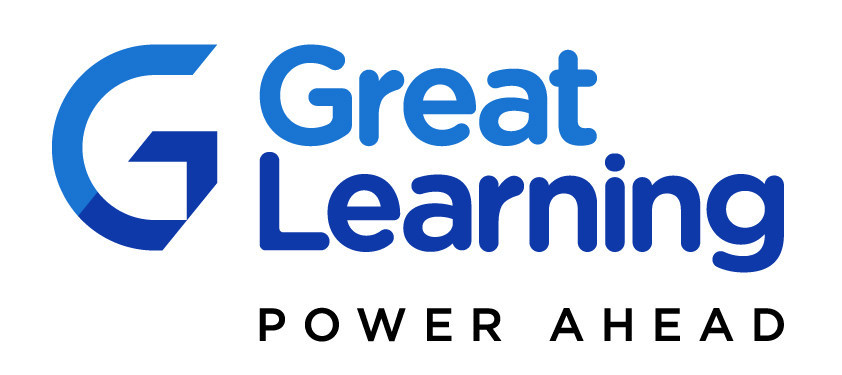

<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=8>Machine Translation Using LSTMs</center></font></h1>
<h1><center>English to French</center></h1>
<h3><center>Charlcye Mitchell, April 2024</center></h3>

#<b>Machine translation based on LSTM

## **Context**
Machine translation (MT) is the process of translating text in one language to another language with the use of software by incorporating both computational and linguistic knowledge.<br></br>  NMT is a recently formulated method for automatic translation with the help of deep neural networks.  NMT uses a single large neural network for training. This structure comprised of encoder and decoder networks where the encoder consumes the input sentences to produce a vector representation, and the decoder takes this vector and outputs the target language words.Generally, both encoder and decoder networks are designed using the recurrent neural networks (RNN) or long short-term memory (LSTM) or gated recurrent unit (GRU) or bidirectional RNN, which are the alternatives to RNN. Even though RNN, especially LSTM, is theoretically proven for handling long-term dependencies in the sentences<br></br>
Here, in this case study we use a simple RNN model combined with lstm nodes for our translation task.

## **Downloading the Required Libraries**

In [ ]:
import numpy as np # Importing the NumPy library for numerical computations.

import tensorflow as tf # Importing the TensorFlow library for machine learning.

from tensorflow import keras # Importing the Keras module from TensorFlow.

from tensorflow.keras.layers import Input # Importing the Input layer from Keras.

from tensorflow.keras import Model # Importing the Model class from Keras.

## **Downloading the Required Dataset**

In [ ]:
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip

['Archive:  fra-eng.zip',
 '  inflating: _about.txt              ',
 '  inflating: fra.txt                 ']

- !!curl -O http://www.manythings.org/anki/fra-eng.zip: This command uses curl to download a file from the specified URL (http://www.manythings.org/anki/fra-eng.zip). The -O flag tells curl to save the downloaded file with the same name as the source file.

- !!unzip fra-eng.zip: This command uses unzip to extract the contents of the fra-eng.zip file. unzip is a utility for extracting files from a ZIP archive. It takes the name of the ZIP file as an argument.



## **Reading and processing the dataset**

In [ ]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on

# Path to the data txt file on disk.
data_path = "fra.txt"

In [ ]:
# Vectorizing the data and storing them in lists
input_texts = []
target_texts = []
'''input_texts and target_texts are empty lists that will store the input and target texts, respectively.'''

# Sets for Creating vocabulary of Input Characters
input_characters = set()
target_characters = set()


'''input_characters and target_characters are sets that will be used to create the vocabulary of unique characters present in the input and target texts, respectively.'''


# Reading File with utf-8 encoding
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")  ##returns a list of lines


'''  opens the file specified by the data_path variable using the open() function, with the encoding set to "utf-8"'''


# Separating input and target texts and storing themin different lists.
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)

    # Adding Unique Characters to the Input Characters array to create vocabulary
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

    ''' These loops iterate over the characters in the input and target texts, respectively.
        They add each unique character to their respective sets
         (input_characters and target_characters) to build the vocabulary.'''

The overall purpose of the above code is to read a text file, extract the input and target texts, and create sets of unique characters present in the input and target texts for further processing or creating a vocabulary.

###  **Check the Dataset**

In [ ]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 14
Max sequence length for outputs: 59


## **Tokenizing and Vectorizing the Text**

Here we are building a Character level translation tool. So each token of our Input text shall be a character and each token of the target text will be a French character. We therefore convert the input data into a three dimensional array. The first dimension consists of number of English to French pairs, the second dimension consists of the length of each sentence. ( Here, we are taking the length of each sentence to be the length of the longest sentence in each of these languages, and for sentences whose lengths are smaller than the highest length, we are padding them with the ' ' token or a blank space token). The third dimension has a length equal to number of unique characters in that particular language, as this vector is a one-hot encoded vector for English and French alphabets.

In [ ]:
# Creating array of zeros with mentioned shape

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

- These lines create dictionaries (input_token_index and target_token_index) that map each unique character in the input and target texts to a unique integer index. These indexes will be used to represent characters in the one-hot encoded vectors.

In [ ]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

The code above creates numpy arrays (encoder_input_data, decoder_input_data, and decoder_target_data) filled with zeros. The shapes of these arrays depend on the number of input texts and the maximum sequence lengths for both the encoder and decoder. num_encoder_tokens and num_decoder_tokens represent the total number of unique characters in the input and target texts, respectively.


In [ ]:
# Populating the arrays
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0 # From (t + 1)th time step, all characters are padded with a blank space character
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

These loops iterate through pairs of input and target texts.
For each character in the input and target texts, it sets the corresponding index in the one-hot encoded vectors to 1.0.
Note that a blank space character is used as a padding character, and it is also represented as a 1.0 in the arrays to ensure consistent sequence lengths.

## **Encoder and Decoder Architecture**

The Architecture has two units, the Encoder LSTM blocks and the Decoder LSTM blocks.

Theoretically in a Sequence to Sequence architecture, the output of the Decoder at one time step is used as an input for the next decoder time step. But during training, we are using the Ground Truth value for the input to the next decoder time step, so that our model learns better. This is called Teacher forcing.

We shall however change this in the inference or the testing stage, where we shall use the more traditional method of using the output of previous decoder time step as the current input to predict the output character.

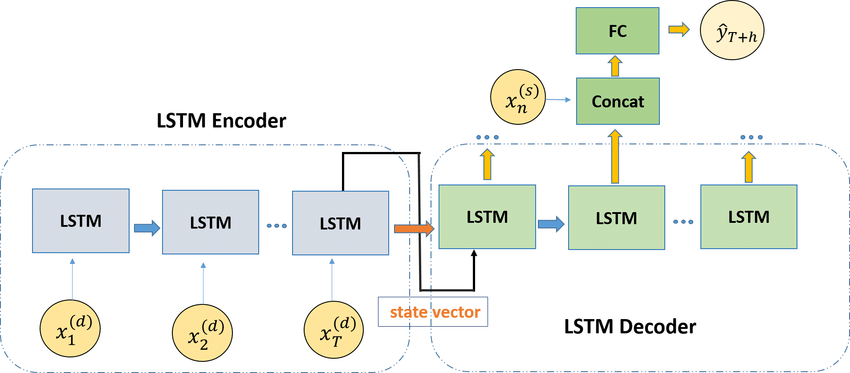

## **Building the Model**

In [ ]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))

# Define an LSTM layer for encoding the input sequence.
encoder = keras.layers.LSTM(latent_dim, return_state=True)

# Pass the input sequence through the LSTM encoder.
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]


- This code sets up the encoder part of a sequence-to-sequence model using an LSTM layer. It takes an input sequence, processes it through the LSTM, and retains the final hidden and cell states as encoder_states. These states will be used to initialize the decoder in a subsequent part of the model.

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# Define an LSTM layer for the decoder.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)

# Pass the decoder inputs through the LSTM decoder with initial states from the encoder.
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Define a dense layer for outputting the decoder predictions.
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")

# Apply the dense layer to the decoder outputs to get the final predictions.
decoder_outputs = decoder_dense(decoder_outputs)


- In a sequence-to-sequence model, the decoder is responsible for generating the target sequence based on the encoder's representation of the input sequence. This code sets up the architecture for the decoder, ensuring that it is connected to the encoder and is capable of producing output sequences.

In [ ]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

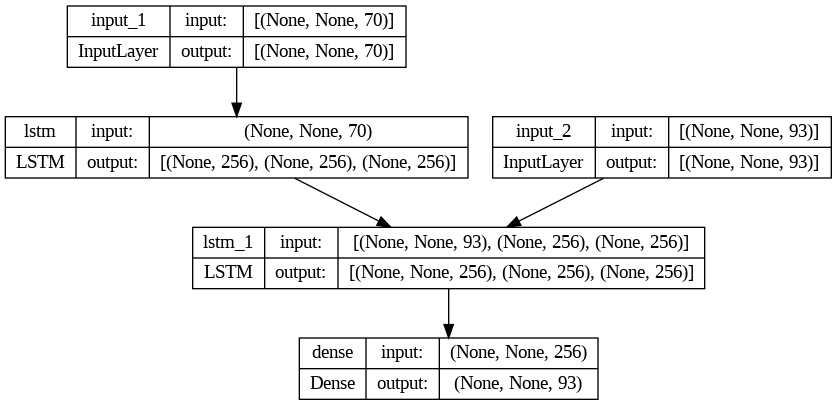

In [ ]:
 # plotting the model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

## **Training the Model**

In [ ]:
# Compile the model with optimizer, loss function, and metrics.
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=["accuracy"])

# Train the model using the prepared data.
model.fit(
    [encoder_input_data, decoder_input_data],  # Input data: encoder and decoder sequences
    decoder_target_data,                       # Target data: decoder target sequences
    batch_size=batch_size,                     # Batch size for training
    epochs=epochs,                             # Number of training epochs
    validation_split=0.2                       # Fraction of data to use for validation
)


Epoch 1/100
125/125 [==============================] - 15s 20ms/step - loss: 1.2201 - accuracy: 0.7333 - val_loss: 1.0920 - val_accuracy: 0.7132
Epoch 2/100
125/125 [==============================] - 2s 12ms/step - loss: 0.9363 - accuracy: 0.7484 - val_loss: 0.9564 - val_accuracy: 0.7325
Epoch 3/100
125/125 [==============================] - 1s 11ms/step - loss: 0.8352 - accuracy: 0.7674 - val_loss: 0.8611 - val_accuracy: 0.7592
Epoch 4/100
125/125 [==============================] - 2s 13ms/step - loss: 0.7466 - accuracy: 0.7934 - val_loss: 0.7786 - val_accuracy: 0.7702
Epoch 5/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6707 - accuracy: 0.8070 - val_loss: 0.7244 - val_accuracy: 0.7936
Epoch 6/100
125/125 [==============================] - 2s 12ms/step - loss: 0.6285 - accuracy: 0.8170 - val_loss: 0.6820 - val_accuracy: 0.8012
Epoch 7/100
125/125 [==============================] - 1s 11ms/step - loss: 0.5989 - accuracy: 0.8247 - val_loss: 0.6540 - val_accuracy

## **Inference Stage**

We have to manually perform inference because, our model had teacher forcing during Training. However, in the Inference Stage, we have to use the output of the previous timestep as the input for next timestep.

In [ ]:
from keras import Model
from keras.layers import Input

In [ ]:
# Create an encoder model that takes encoder_inputs and outputs encoder_states.
encoder_model = Model(encoder_inputs, encoder_states)

# Define input tensors for the initial state of the decoder (hidden state and cell state).
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Connect decoder_inputs to the LSTM decoder using initial states.
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)

# Gather the updated decoder states (hidden state and cell state).
decoder_states = [state_h, state_c]

# Apply the decoder dense layer to obtain the final predictions.
decoder_outputs = decoder_dense(decoder_outputs)

# Create a decoder model that takes decoder inputs and initial decoder states,
# and outputs decoder predictions and updated decoder states.
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)


In [ ]:
# Create a dictionary that maps integer indexes to input characters.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())

# Create a dictionary that maps integer indexes to target characters.
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


In [ ]:
# decoding the output sentence from output tokenized data
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the firhttps://colab.research.google.com/drive/1POsKAPn78VkMMTseSTQm1w7a8RsrTa-W#scrollTo=_Az5ZhvbgHQyst character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence



- states_value is obtained by encoding the input sequence using the encoder_model.

- An empty target sequence of length 1 is generated.

- The first character of the target sequence is populated with the start character.

- A sampling loop is initiated to generate the output tokens for the sequence. It continues until a stop condition is met, which can be either reaching the maximum length or encountering the stop character.

- In each iteration of the loop, the decoder_model predicts the output tokens and the corresponding hidden states (h and c). The output_tokens represent the probabilities of each token in the output sequence.

- The token with the highest probability is selected as the sampled token, and the corresponding character is retrieved using reverse_target_char_index.

- The sampled character is appended to the decoded_sentence.

- The loop continues until the stop condition is met.

- The target sequence is updated by setting the sampled token as the next input.

- The hidden states (h and c) are updated with the new states.

- Finally, the decoded_sentence is returned as the output.

## **Testing our Model**

In [ ]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

1/1 [==============================] - 0s 20ms/step
-
Input sentence: Go.
Decoded sentence: Sortez.

1/1 [==============================] - 0s 19ms/step
-
Input sentence: Go.
Decoded sentence: Sortez.

1/1 [==============================] - 0s 25ms/step
-
Input sentence: Go.
Decoded sentence: Sortez.

1/1 [==============================] - 0s 24ms/step
-
Input sentence: Go.
Decoded sentence: Sortez.

1/1 [==============================] - 0s 18ms/step
-
Input sentence: Hi.
Decoded sentence: Salut !

1/1 [==============================] - 0s 20ms/step
-
Input sentence: Hi.
Decoded sentence: Salut !

1/1 [==============================] - 0s 20ms/step
-
Input sentence: Run!
Decoded sentence: Fuyons !

1/1 [==============================] - 0s 23ms/step
-
Input sentence: Run!
Decoded sentence: Fuyons !

1/1 [==============================] - 0s 22ms/step
-
Input sentence: Run!
Decoded sentence: Fuyons !

1/1 [==============================] - 0s 21ms/step
-
Input sentence: Run!
Decoded se

In [ ]:
for seq_index in range(2):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

1/1 [==============================] - 0s 22ms/step
-
Input sentence: Go.
Decoded sentence: Sortez.

1/1 [==============================] - 0s 22ms/step
-
Input sentence: Go.
Decoded sentence: Sortez.



### **LSTM model on Unseen data**

In [ ]:
def decode_sequence(states_value, max_decoder_seq_length):
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of the target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences (assuming batch size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        # Predict the output tokens and update hidden states.
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token by selecting the one with the highest probability.
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit the maximum length
        # or find the stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence


In [ ]:
import numpy as np

# Tokenize the input sentence (you may use your tokenizer)
def tokenize_input(input_text):
    # Implement your tokenization logic here, e.g., using nltk or spaCy
    # This is a simplified example, assuming whitespace-based tokenization
    return input_text.split()

# Convert tokens to one-hot encoded sequences
def one_hot_encode(tokens, token_index, max_sequence_length):
    num_tokens = len(token_index)
    input_seq = np.zeros((1, max_sequence_length, num_tokens), dtype="float32")
    for t, token in enumerate(tokens):
        token_idx = token_index.get(token, 0)  # Use 0 for unknown tokens
        input_seq[0, t, token_idx] = 1.0
    return input_seq

# Pad the one-hot encoded sequence
def pad_sequence(input_seq, max_sequence_length):
    if input_seq.shape[1] < max_sequence_length:
        pad_width = max_sequence_length - input_seq.shape[1]
        input_seq = np.pad(input_seq, ((0, 0), (0, pad_width), (0, 0)), mode='constant')
    return input_seq

# Preprocess the input sentence
def preprocess_input(input_text):
    # Tokenize the input text
    tokens = tokenize_input(input_text)

    # One-hot encode the tokens
    input_seq = one_hot_encode(tokens, input_token_index, max_encoder_seq_length)

    # Pad the input sequence to match the expected shape
    input_seq = pad_sequence(input_seq, max_encoder_seq_length)

    return input_seq


In [ ]:
while True:
    user_input = input("Enter a sentence (or 'exit' to quit): ")

    if user_input.lower() == 'exit':
        break

    input_seq = preprocess_input(user_input)  # Preprocess user input
    states_value = encoder_model.predict(input_seq)  # Encode user input
    decoded_output = decode_sequence(states_value, max_decoder_seq_length)
     # Generate output

    print("Generated Output:", decoded_output)

Enter a sentence (or 'exit' to quit): go
1/1 [==============================] - 0s 22ms/step
Generated Output: J'adore le rouveau.

Enter a sentence (or 'exit' to quit): I love the novel
1/1 [==============================] - 0s 24ms/step
Generated Output: Je ne peux pas morter.

Enter a sentence (or 'exit' to quit): help
1/1 [==============================] - 0s 19ms/step
Generated Output: J'adore le rouveau.

Enter a sentence (or 'exit' to quit): what is your name?
1/1 [==============================] - 0s 36ms/step
Generated Output: Suis-je en train de rêver ?

Enter a sentence (or 'exit' to quit): quit
1/1 [==============================] - 0s 24ms/step
Generated Output: J'adore le rouveau.

Enter a sentence (or 'exit' to quit): exit


There can be several reasons why our LSTM-based machine translation model performs well on the training data but poorly on unseen data. Here are some common issues:

- **Data Mismatch**: The training data may not be representative of the unseen data. This can happen if the training data is from a different domain, has a different distribution, or is not large enough to capture the diversity of possible inputs.

- **Lack of Generalization**: Our model may not be generalizing well from the training data to unseen data


- **Low Quantity of Training Data**: With a small amount of training data, our model may struggle to generalize effectively and capture the nuances of the translation task.


- **Missing Attention Mechanism** : Attention mechanisms are crucial for capturing dependencies between different parts of the input and output sequences, especially in long sequences. Without attention, your model may struggle with longer or more complex translations.



## **Conclusion**

- The model is trained on Character basis, therefore the model focuses more on the translatory accuracy of each words.
- We can try testing our model over a different range of data. For that we shall need to change the sequence indexes in the iterator for generating these results.